In [1]:
@info pwd()
import Pkg.activate as pactivate
pactivate("../../")
JULIA_DEBUG=Main
using Plots, Statistics, DelimitedFiles, Unitful
pyplot()

[ Info: /Users/jun/codes/SPM.jl/test/notebooks
  Activating project at `~/codes/SPM.jl`


Plots.PyPlotBackend()

In [2]:
include("../../src/SPM.jl")

Main.SPM

[ Info: (10, 10)
[ Info: (30, 30)


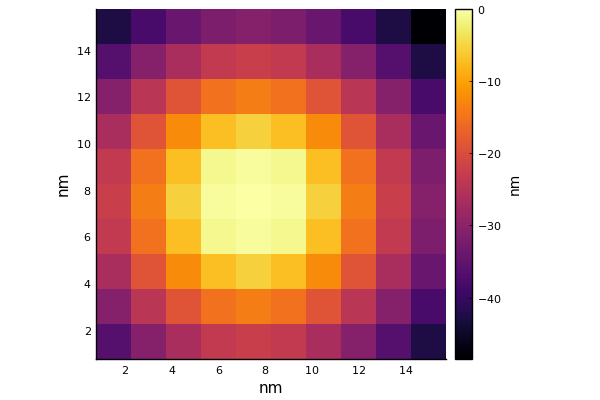

In [50]:
using BSON: @load
@load "../data/single_tip_test_data.bson" resolution tip surfs images images_randn
resolution = resolution / 10.0 # 解像度[nm/px]
# 変換、画素値は\AAからnmに変換
surfs = [SPM.Image(mat/10.0, resolution) for mat in surfs] # 実表面
images = [SPM.Image(mat/10.0, resolution) for mat in images] # ノイズなし画像
noisy_images = [SPM.Image(mat/10.0, resolution) for mat in images_randn] # ノイズあり画像
true_tip = SPM.Tip(tip/10.0, resolution) # 探針

noisy_images = noisy_images[1:9]

@info size(true_tip.data)
@info size(images[1].data)
SPM.Plots.heatmap(true_tip)

[ Info: (30, 30)


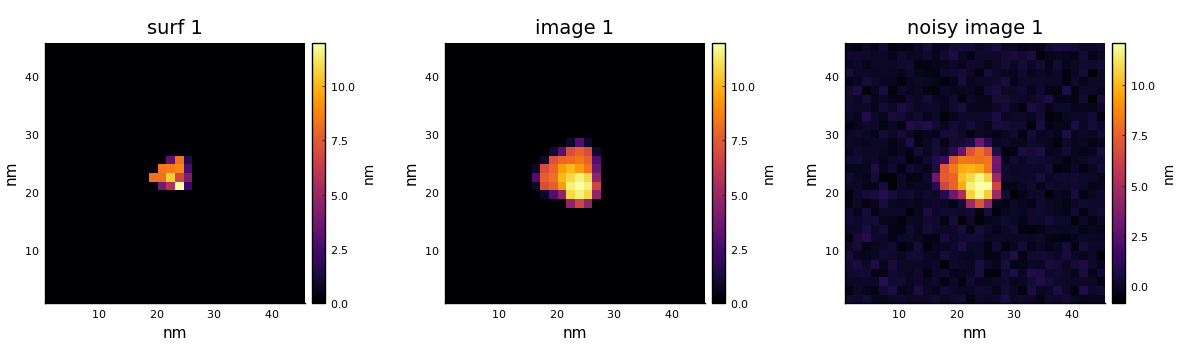

In [59]:
ps = Vector{Plots.Plot}(undef, 3)
for i in 0:0
    ps[3i+1] = SPM.Plots.heatmap(surfs[i+1]; title="surf $(i+1)")
    ps[3i+2] = SPM.Plots.heatmap(images[i+1]; title="image $(i+1)")
    ps[3i+3] = SPM.Plots.heatmap(noisy_images[i+1]; title="noisy image $(i+1)")
end
@info size(images[1].data)
plot(ps..., layout=(1,3), size=(1200, 360))

In [55]:
downscale_ratio = 1
tip_size = div(size(true_tip.data, 1), downscale_ratio)
max_epoch = 80
lambdas = [1.0e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-0, 5, 10]
@time results = SPM.BTR.solveDifferentiableBTR(
    noisy_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=0
)
println(typeof(results))

[ Info: 1th thread : start solving for lambda = 0.01
[ Info: 3th thread : start solving for lambda = 1.0e-10
[ Info: 2th thread : start solving for lambda = 5.0
[ Info: 4th thread : start solving for lambda = 0.0001
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 3th thread : 80th epoch completed in 1.285 sec
[ Info: 4th thread : 4th lambda completed
[ Info: 2th thread : start solving for lambda = 0.001
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : 80th epoch completed in 1.289 sec
[ Info: 4th thread : 6th lambda completed
[ Info: 4th thread : start solving for lambda = 1.0
[ Info: 3th thread : optimizer setup completed
[ Info: 3th thread : 80th epoch completed in 1.293 sec
[ Info: 1th thread : 8th lambda completed
[ Info: 2th thread : start solving for lambda = 10.0
[ Info: 2th thread : optimizer setup completed
[ Inf

  3.229702 seconds (3.87 M allocations: 1.879 GiB, 34.55% gc time)
Vector{Main.SPM.BTR.DifferentiableBTRResult}


[ Info: 1th thread : 80th epoch completed in 0.745 sec
[ Info: 4th thread : 3th lambda completed


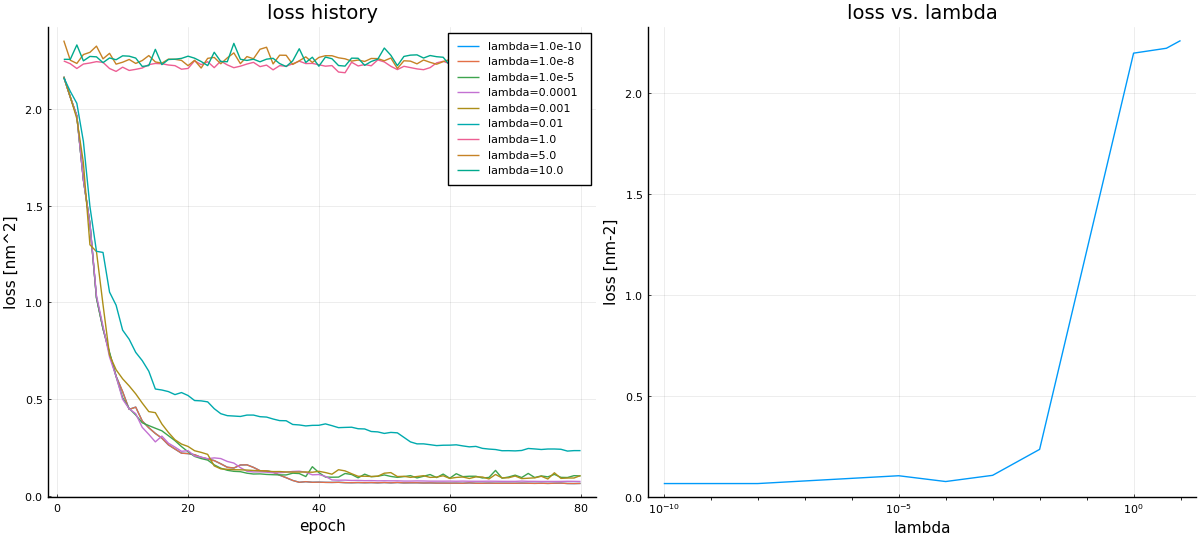

In [56]:
ps = Vector{Plots.Plot}(undef, 2)

ps[1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
for it in eachindex(lambdas)
    plot!(ps[1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
end

ps[2] = plot(
    lambdas, [result.loss_history[end] for result in results],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda", legend=nothing
)

plot(ps..., layout=(1,2), size=(1200, 540))

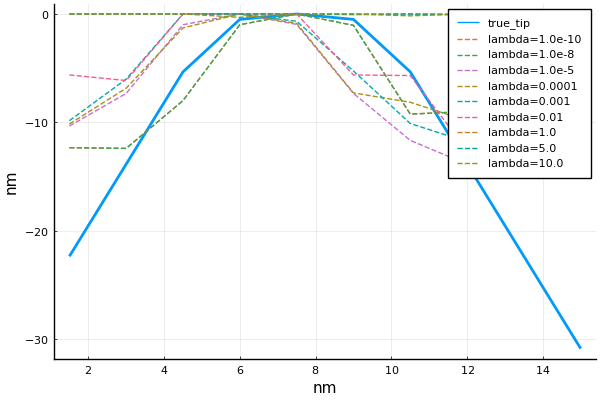

In [57]:
slice_direction = :x
i_slice = div(size(results[1].tip.data,1), 2) 
p = SPM.Plots.plotProfile(true_tip, slice_direction, i_slice; linewidth=2, label="true_tip")
for result in results
    p = SPM.Plots.plotProfile!(p, result.tip, slice_direction, i_slice; linestyle=:dash, label="lambda=$(result.lambda)")
end
p

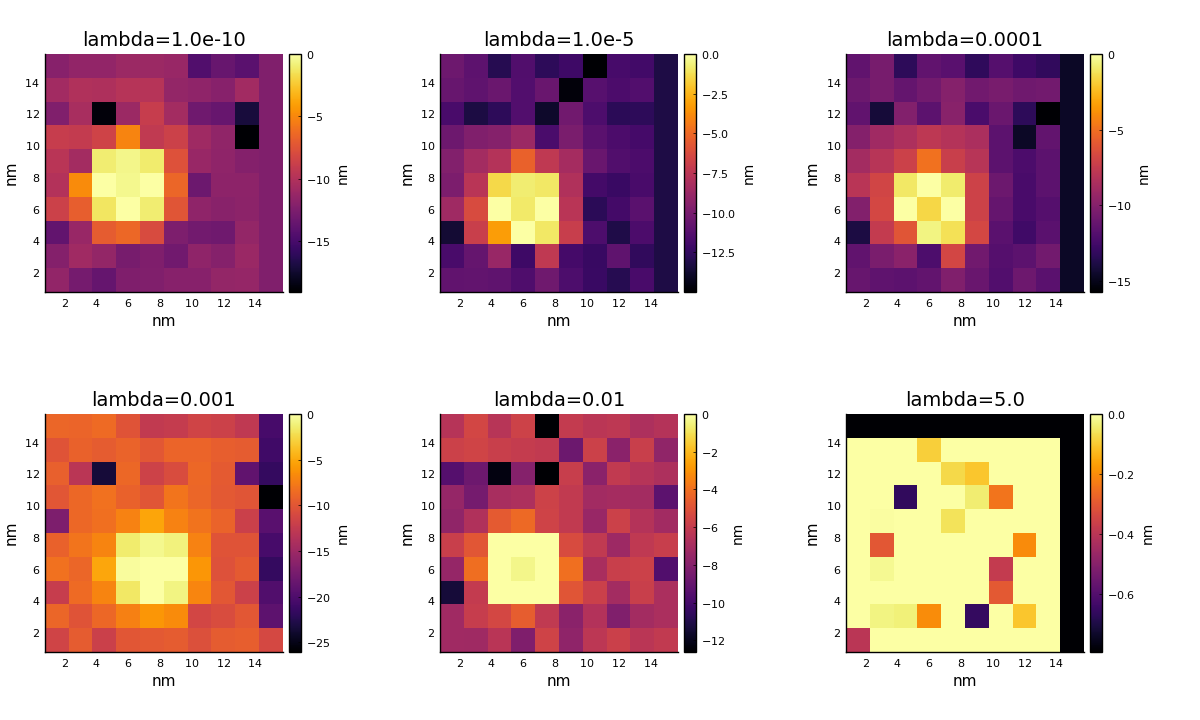

In [58]:
ps = Vector{Plots.Plot}(undef, 6)
# ps[1] = SPM.Plots.heatmap(true_tip; title="true tip")
for (i, i_lambda) in zip(1:6, [1,3,4,5,6,8])
    result = results[i_lambda]
    ps[i] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
end
plot(ps..., layout=(2,3), size=(1200, 720))

[ Info: size:(512, 512)   resolution:0.1953125


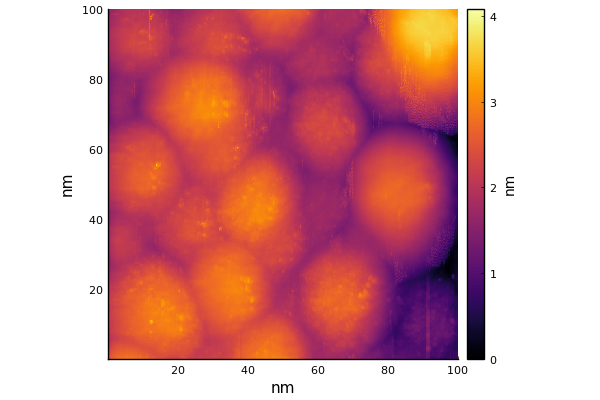

In [9]:
image = SPM.HDR.loadHDR("../data/B3446.hdr")
@info "size:$(size(image.data))   resolution:$(image.resolution)"
SPM.Plots.heatmap(image; legend=true)

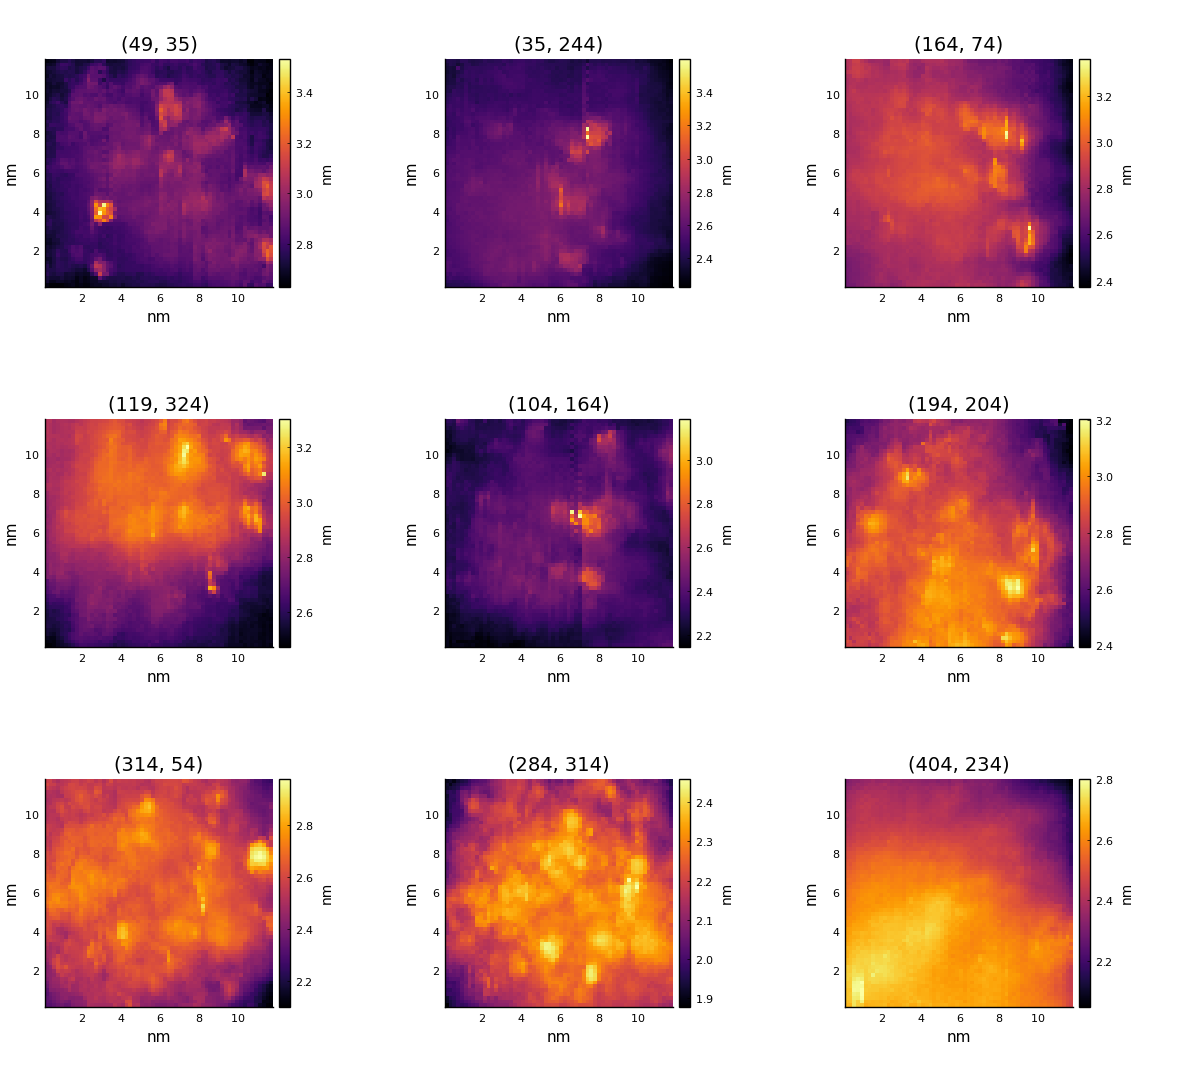

In [10]:
halfwidth = 30
extract_size = (2*halfwidth, 2*halfwidth)
centers = [
    (79,65), (65,274), (194, 104), 
    (149,354), (134,194), (224,234), 
    (344,84), (314,344), (434,264)
]
lowerlefts = [(p[1]-halfwidth, p[2]-halfwidth) for p in centers]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = SPM.extract(image, lowerlefts, extract_size)
for i = eachindex(lowerlefts)
    plots[i] = SPM.Plots.heatmap(extracted_images[i]; title="$(lowerlefts[i])", legend=true)
end

plot(plots..., layout=(3,3), size=(1200, 1080))

In [23]:
downscale_ratio = 1
tip_size = 20
max_epoch = 200
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
@time normalResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, normalResults, "normalResults")

[ Info: 1th thread : start solving for lambda = 0.01
[ Info: 2th thread : start solving for lambda = 1.0e-11
[ Info: 3th thread : start solving for lambda = 1.0e-8
[ Info: 4th thread : start solving for lambda = 1.0e-5
[ Info: 3th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 1th thread : 20th epoch completed in 2.844 sec
[ Info: 4th thread : 20th epoch completed in 2.872 sec
[ Info: 2th thread : 20th epoch completed in 2.919 sec
[ Info: 4th thread : 20th epoch completed in 2.929 sec
[ Info: 1th thread : 40th epoch completed in 5.67 sec
[ Info: 4th thread : 40th epoch completed in 5.686 sec
[ Info: 1th thread : 40th epoch completed in 5.697 sec
[ Info: 4th thread : 40th epoch completed in 5.707 sec
[ Info: 2th thread : 60th epoch completed in 8.411 sec
[ Info: 2th thread : 60th epoch completed in 8.414 sec
[ Info: 2th thread : 60th epoch completed in

[ Info: 1th thread : 160th epoch completed in 22.015 sec
[ Info: 2th thread : 180th epoch completed in 24.417 sec
[ Info: 1th thread : 180th epoch completed in 24.475 sec
[ Info: 1th thread : 180th epoch completed in 24.528 sec
[ Info: 3th thread : 180th epoch completed in 24.721 sec
[ Info: 2th thread : 200th epoch completed in 27.175 sec
[ Info: 4th thread : 5th lambda completed
[ Info: 3th thread : start solving for lambda = 1.0e-6
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : 200th epoch completed in 27.244 sec
[ Info: 3th thread : 8th lambda completed
[ Info: 4th thread : start solving for lambda = 0.001
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 200th epoch completed in 27.28 sec
[ Info: 3th thread : 2th lambda completed
[ Info: 3th thread : start solving for lambda = 1.0e-9
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : 200th epoch completed in 27.354 sec
[ Info: 1th thread : 11th lambda completed
[ Info: 4th th

 83.161613 seconds (26.37 M allocations: 43.119 GiB, 10.59% gc time)


[ Info: 3th thread : 200th epoch completed in 28.037 sec
[ Info: 3th thread : 12th lambda completed


true

In [12]:
downscale_ratio = 2
tip_size = 20
max_epoch = 200
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
@time downScaledResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, downScaledResults, "downScaledResults")

[ Info: 4th thread : start solving for lambda = 0.01
[ Info: 1th thread : start solving for lambda = 1.0e-11
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : start solving for lambda = 1.0e-5
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : 20th epoch completed in 13.126 sec
[ Info: 1th thread : 20th epoch completed in 13.127 sec
[ Info: 4th thread : 20th epoch completed in 13.299 sec
[ Info: 4th thread : 20th epoch completed in 13.438 sec
[ Info: 3th thread : 40th epoch completed in 25.748 sec
[ Info: 1th thread : 40th epoch completed in 26.014 sec
[ Info: 1th thread : 40th epoch completed in 26.33 sec
[ Info: 3th thread : 40th epoch completed in 26.461 sec
[ Info: 3th thread : 60th epoch completed in 38.704 sec
[ Info: 1th thread : 60th epoch completed in 39.159 sec
[ Info: 4th thread : 60th epoch co

[ Info: 1th thread : 160th epoch completed in 108.742 sec
[ Info: 3th thread : 160th epoch completed in 108.524 sec
[ Info: 4th thread : 160th epoch completed in 107.833 sec
[ Info: 4th thread : 180th epoch completed in 120.66 sec
[ Info: 2th thread : 180th epoch completed in 121.724 sec
[ Info: 1th thread : 180th epoch completed in 120.16 sec
[ Info: 4th thread : 180th epoch completed in 121.139 sec
[ Info: 3th thread : 200th epoch completed in 133.987 sec
[ Info: 3th thread : 8th lambda completed
[ Info: 3th thread : start solving for lambda = 0.001
[ Info: 3th thread : optimizer setup completed
[ Info: 1th thread : 200th epoch completed in 134.443 sec
[ Info: 1th thread : 11th lambda completed
[ Info: 4th thread : start solving for lambda = 1.0
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : 200th epoch completed in 132.909 sec
[ Info: 2th thread : 2th lambda completed
[ Info: 3th thread : start solving for lambda = 1.0e-9
[ Info: 3th thread : 200th epoch complet

397.036932 seconds (78.22 M allocations: 131.203 GiB, 8.42% gc time)


true

In [13]:
downscale_ratio = 1
tip_size = 40
max_epoch = 200
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
@time largeGridResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, largeGridResults, "largeGridResults")

[ Info: 3th thread : start solving for lambda = 0.01
[ Info: 1th thread : start solving for lambda = 1.0e-11
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : start solving for lambda = 1.0e-5
[ Info: 1th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 20th epoch completed in 16.342 sec
[ Info: 3th thread : 20th epoch completed in 16.358 sec
[ Info: 4th thread : 20th epoch completed in 16.383 sec
[ Info: 3th thread : 20th epoch completed in 16.639 sec
[ Info: 4th thread : 40th epoch completed in 30.868 sec
[ Info: 2th thread : 40th epoch completed in 30.908 sec
[ Info: 1th thread : 40th epoch completed in 30.937 sec
[ Info: 3th thread : 40th epoch completed in 31.374 sec
[ Info: 1th thread : 60th epoch completed in 45.411 sec
[ Info: 4th thread : 60th epoch completed in 45.488 sec
[ Info: 3th thread : 60th epoch c

[ Info: 2th thread : 160th epoch completed in 116.136 sec
[ Info: 1th thread : 160th epoch completed in 116.252 sec
[ Info: 1th thread : 160th epoch completed in 116.756 sec
[ Info: 2th thread : 180th epoch completed in 129.867 sec
[ Info: 4th thread : 180th epoch completed in 130.267 sec
[ Info: 3th thread : 180th epoch completed in 130.582 sec
[ Info: 2th thread : 180th epoch completed in 130.288 sec
[ Info: 1th thread : 200th epoch completed in 143.996 sec
[ Info: 4th thread : 8th lambda completed
[ Info: 4th thread : start solving for lambda = 0.001
[ Info: 4th thread : optimizer setup completed
[ Info: 3th thread : 200th epoch completed in 144.08 sec
[ Info: 1th thread : 2th lambda completed
[ Info: 1th thread : start solving for lambda = 1.0e-9
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : 200th epoch completed in 144.384 sec
[ Info: 2th thread : 11th lambda completed
[ Info: 1th thread : start solving for lambda = 1.0
[ Info: 4th thread : optimizer setup co

436.696815 seconds (78.22 M allocations: 441.182 GiB, 12.48% gc time)


[ Info: 3th thread : 200th epoch completed in 144.071 sec
[ Info: 3th thread : 12th lambda completed


true

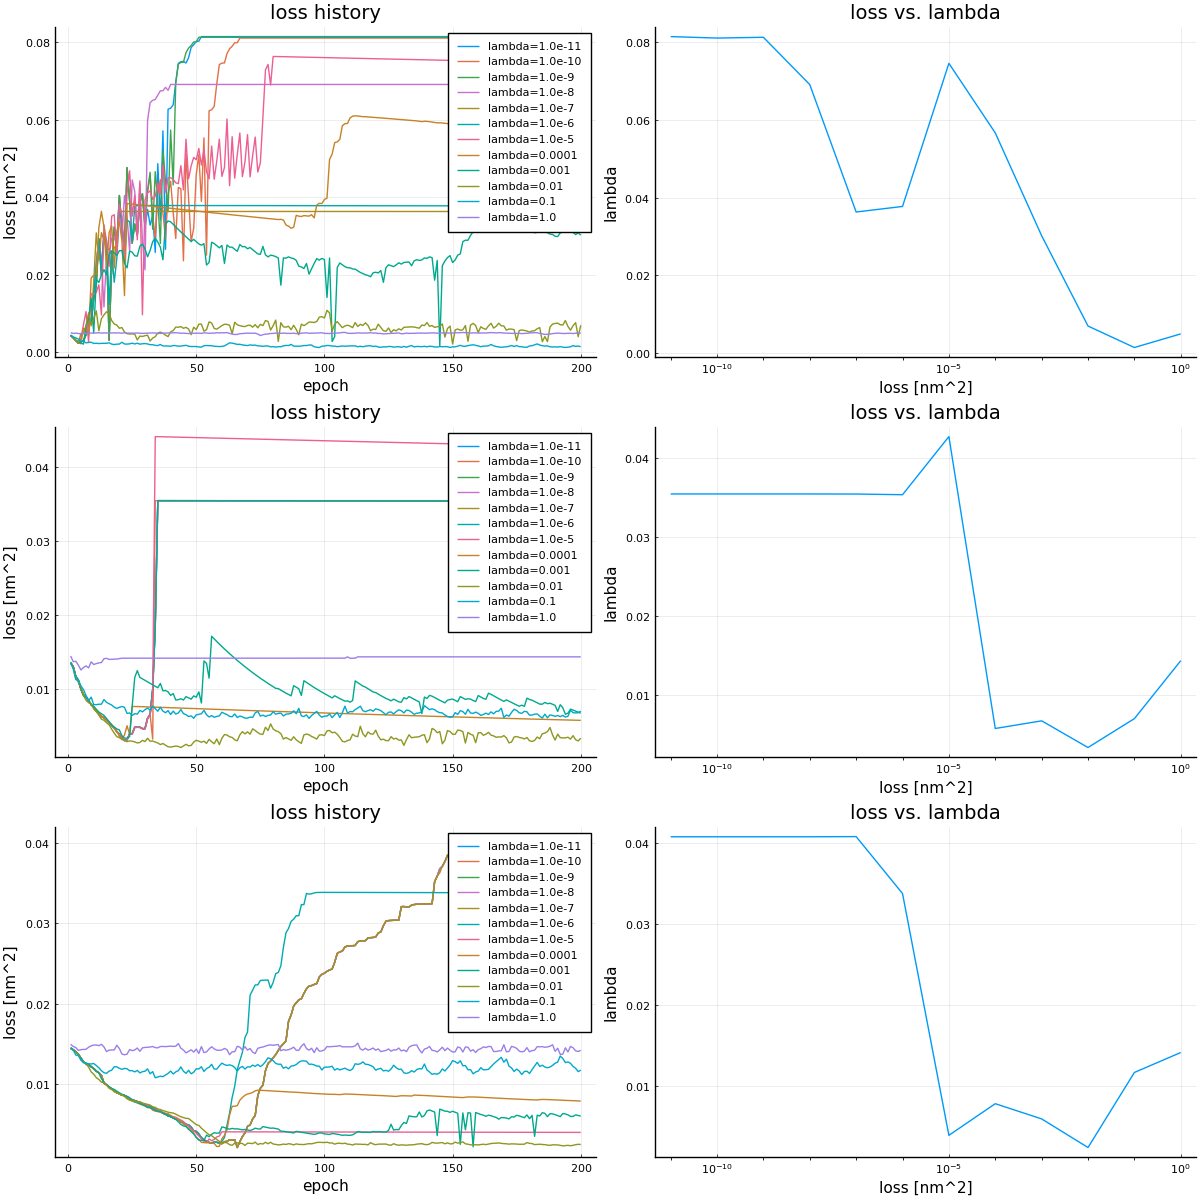

In [25]:
ps = Vector{Plots.Plot}(undef, 6)

for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    ps[2*i-1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
    max_epoch = results[1].max_epoch
    for it in eachindex(lambdas)
        plot!(ps[2*i-1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
    end

    ps[2*i] = plot(
        lambdas, [result.loss_history[end] for result in results],
        xaxis=:log, xlabel="loss [nm^2]", ylabel="lambda", title="loss vs. lambda", legend=nothing
    )
end

plot(ps..., layout=(3,2), size=(1200, 1200))

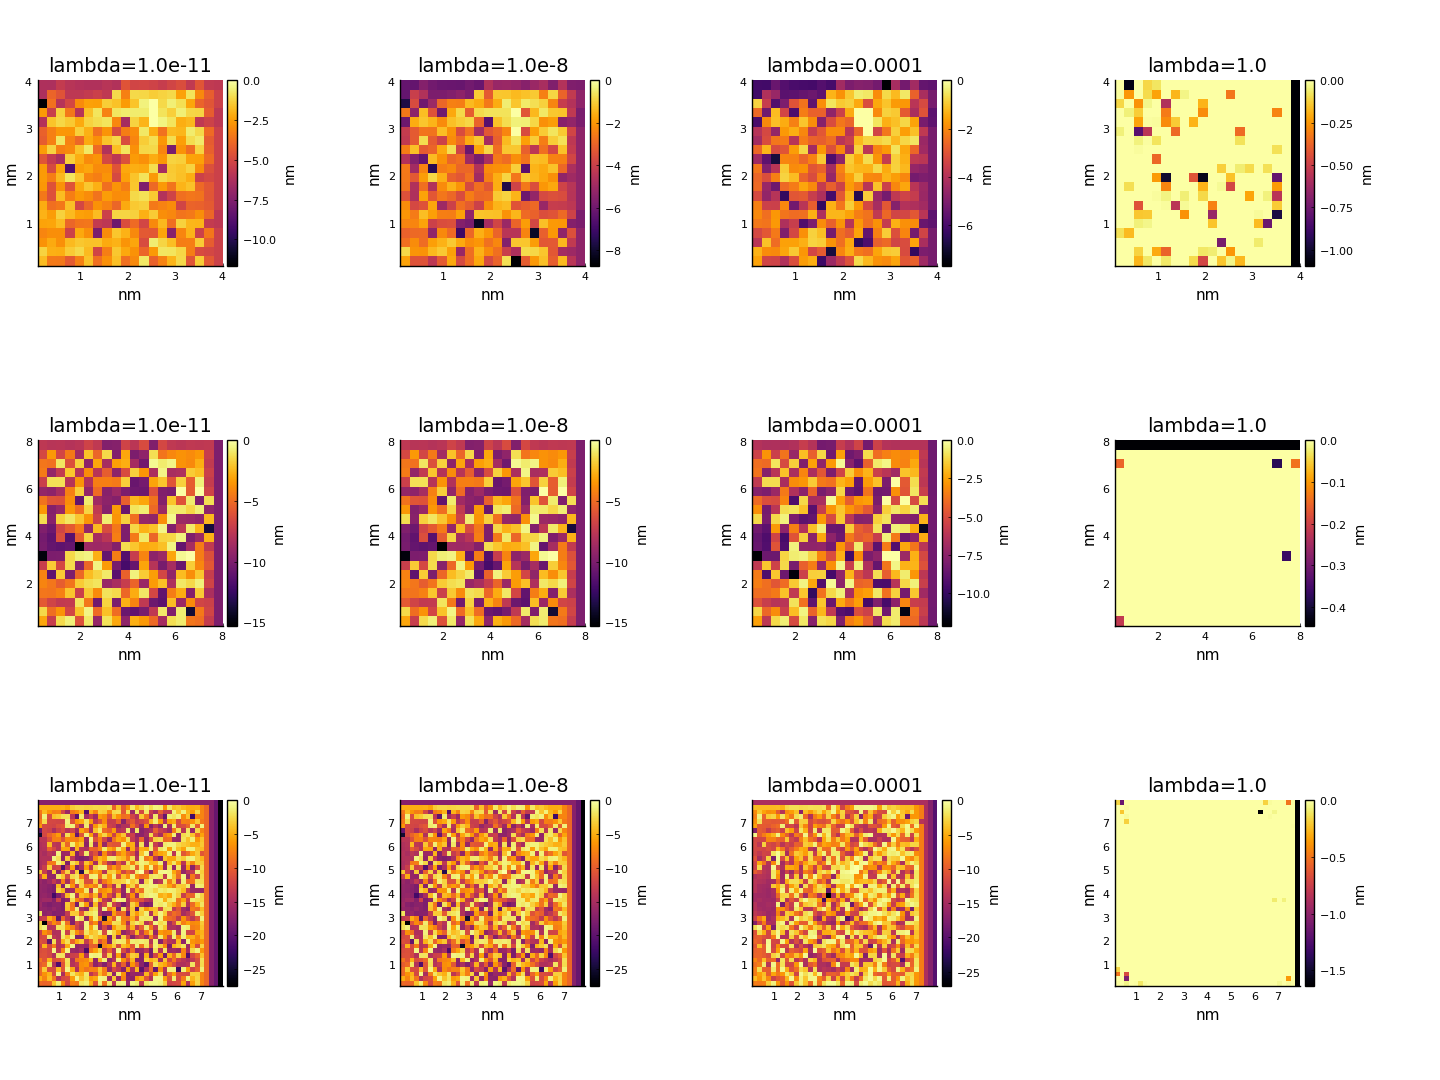

In [18]:
ps = Vector{Plots.Plot}(undef, 12)

titles = ["grid size:20, D.S. ratio:1", "grid size:20, D.S. ratio:2", "grid size:40, D.S. ratio:1"]
for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    row=(i-1)*4
    results_tmp = [results[1], results[4], results[8], results[12]]
    for (j, result) in enumerate(results_tmp)
        title = "$(titles[i]) (l=$(result.lambda))"
        ps[row+j] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
    end
end
plot(ps..., layout=(3,4), size=(1440, 1080))

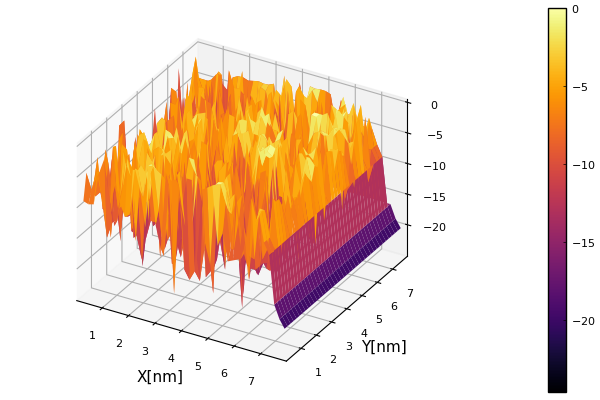

In [22]:
rec_tmp = deepcopy(largeGridResults[7].tip.data)
rec_tmp[rec_tmp .< -25.0] .= NaN
width = size(rec_tmp,1)
resolution = largeGridResults[1].tip.resolution
plot(
    collect(1:width) .* resolution, collect(1:width) .* resolution, rec_tmp,
    st=:surface, xlabel="X[nm]", ylabel="Y[nm]"
)

[ Info: size:(512, 512)   resolution:0.4


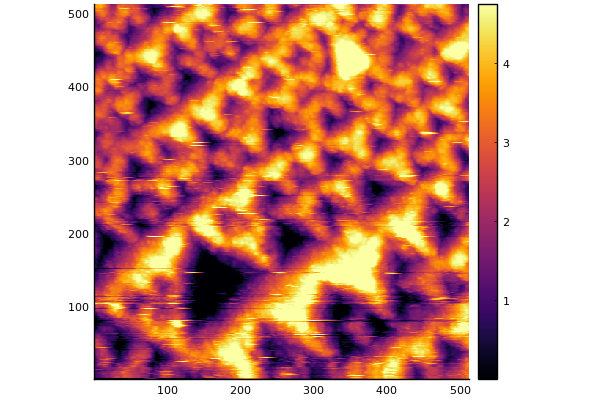

In [31]:
image = SPM.HDR.loadHDR("../data/20001.hdr")
@info "size:$(size(image.data))   resolution:$(image.resolution)"
# SPM.Plots.heatmap(image; legend=true)
Plots.heatmap(image.data; aspectratio=:equal)

[ Info: (60, 60)


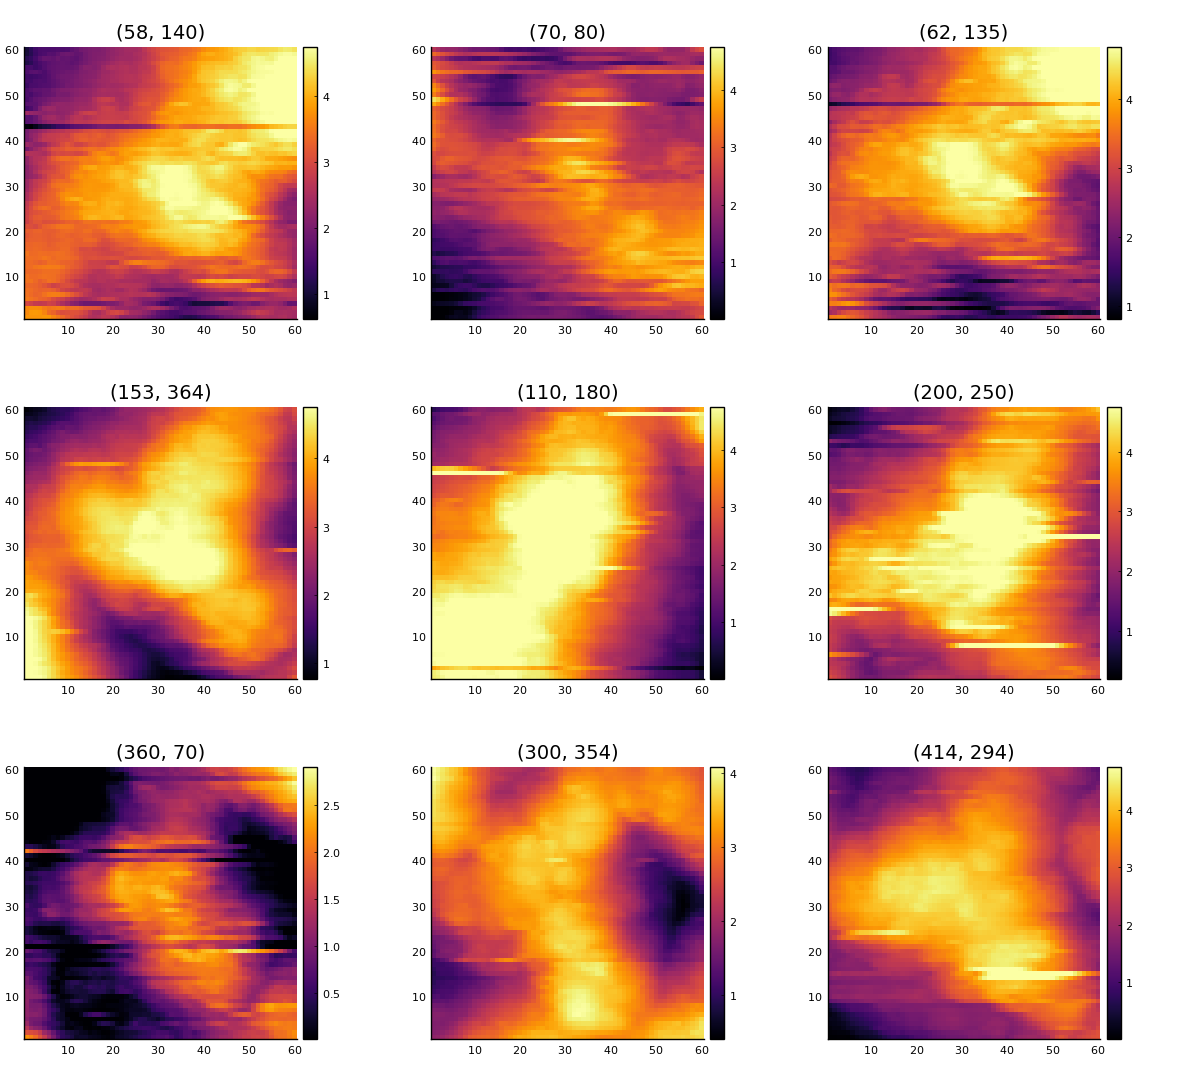

In [67]:
halfwidth = 30
extract_size = (2*halfwidth, 2*halfwidth)
centers = [
    (58,140), (70,80), (62,135), 
    (153,364), (110,180), (200,250), 
    (360,70), (300,354), (414,294)
]
lowerlefts = [(p[1]-halfwidth, p[2]-halfwidth) for p in centers]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = SPM.extract(image, lowerlefts, extract_size)
for i = eachindex(lowerlefts)
    plots[i] = Plots.heatmap(extracted_images[i].data; title="$(centers[i])", aspectratio=:equal)
end

@info size(extracted_images[1].data)
plot(plots..., layout=(3,3), size=(1200, 1080))

In [81]:
downscale_ratio = 2
tip_size = 10
max_epoch = 60
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# lambdas = [1.0e-11, 1e-8, 1e-5, 1e-2]
@time normalResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
@info "finished"
# SPM.BTR.saveResults(extracted_images, normalResults, "normalResults_sharp_tip")

[ Info: 1th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : start solving for lambda = 0.01
[ Info: 2th thread : start solving for lambda = 1.0e-5
[ Info: 4th thread : start solving for lambda = 1.0e-11
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : 20th epoch completed in 2.687 sec
[ Info: 3th thread : 20th epoch completed in 2.736 sec
[ Info: 3th thread : 20th epoch completed in 2.786 sec
[ Info: 2th thread : 20th epoch completed in 2.83 sec
[ Info: 2th thread : 40th epoch completed in 5.446 sec
[ Info: 1th thread : 40th epoch completed in 5.518 sec
[ Info: 3th thread : 40th epoch completed in 5.546 sec
[ Info: 4th thread : 40th epoch completed in 5.547 sec
[ Info: 3th thread : 60th epoch completed in 8.147 sec
[ Info: 3th thread : 7th lambda completed
[ Info: 2th thread : start solving for lambda = 0.0001
[ 

 24.025184 seconds (7.90 M allocations: 6.940 GiB, 8.01% gc time)


[ Info: 2th thread : 60th epoch completed in 7.755 sec
[ Info: 2th thread : 6th lambda completed
[ Info: 1th thread : 60th epoch completed in 7.691 sec
[ Info: 1th thread : 12th lambda completed
[ Info: 1th thread : 60th epoch completed in 7.73 sec
[ Info: 1th thread : 3th lambda completed
[ Info: finished


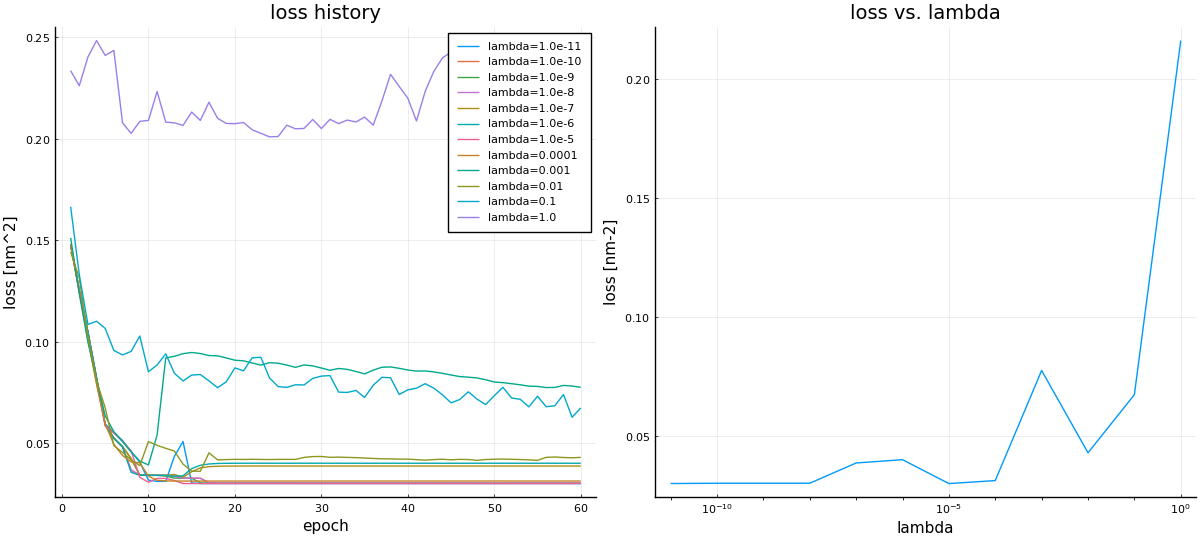

In [82]:
ps = Vector{Plots.Plot}(undef, 2)
ps[1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
for it in eachindex(lambdas)
    plot!(ps[1], collect(1:max_epoch), normalResults[it].loss_history, label="lambda=$(lambdas[it])")
end
ps[2] = plot(
    lambdas, [result.loss_history[end] for result in normalResults],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda", legend=nothing
)
plot(ps..., layout=(1,2), size=(1200, 540))

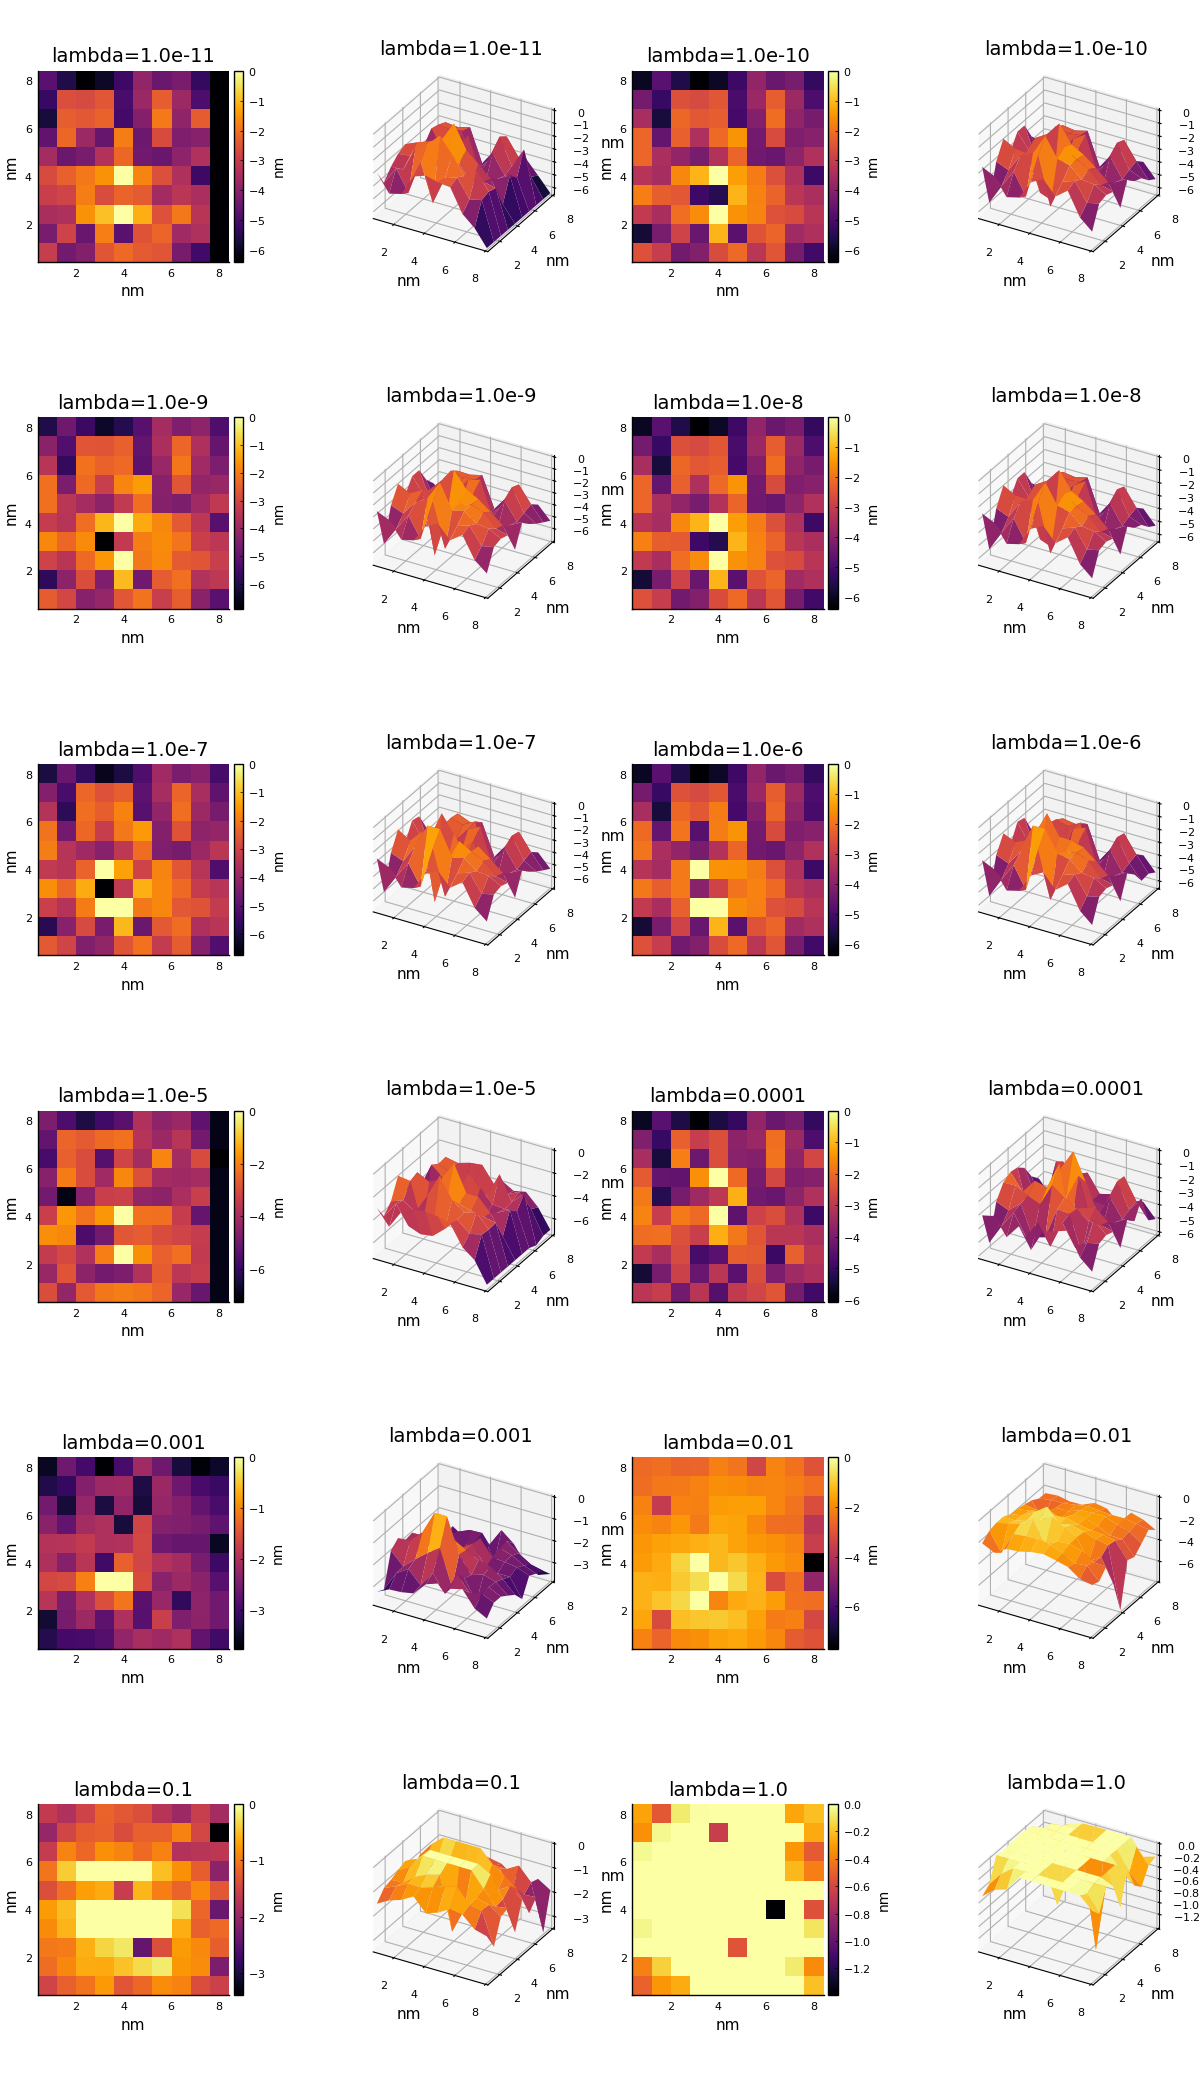

In [85]:
ps = Vector{Plots.Plot}(undef, 24)
for (i, result) in enumerate(normalResults)
    tip = result.tip
    ps[2i-1] = SPM.Plots.heatmap(tip, title="lambda=$(result.lambda)")
    x_mesh = collect(1:size(tip.data, 2)) .* tip.resolution * SPM.DEFAULT_UNIT
    y_mesh = collect(1:size(tip.data, 1)) .* tip.resolution * SPM.DEFAULT_UNIT
    ps[2i] = plot(
        x_mesh, y_mesh, tip.data .* SPM.DEFAULT_UNIT,
        st=:surface, title="lambda=$(result.lambda)", legend=nothing
    )
end
plot(ps..., layout=(6,4), size=(1200, 2080))